In [1]:
'''
Analysis of A and B Products
Ad Hoc Request Steve Lewis
Before and after switch from layered to full pallet
Jan 1 - Dec 27 2016

Input data for A/B products from Steve L.
Inbound shipment data from pw_polines AS400
YTD Sales data from ytd_prod

Data transferred into a CSV
from Transfer Add In, outside of Excel
'''
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime as dt
import datetime
import re

pd.set_option('display.float_format', lambda x: '%.3f' % x)

path = 'C:/Users/pmwash/Desktop/Re-Engineered Reports/Ad Hoc/Purchasing/Full Pallet v Layered/'

## Daily Sales by Product for Aggregating up to Weekly
def generate_pw_ytdpwar(path):
    '''This is a huge file, so this function makes it manageable '''
    def as400_date(dat):
        try:
            d = dt.date(dt.strptime(dat[-6:], '%y%m%d'))
        except ValueError:
            d = dt.date(dt.strptime('1990909', '%y%m%d'))
        return d
    ## Generate the dataframe from messy data
    pw_ytdpwar = pd.read_csv(path + 'pw_ytdpwar Jan - Dec 2016.csv', header=None)
    l = [re.sub(' +',',',STRING) for STRING in pw_ytdpwar[0].astype(str)]
    pw_ytdpwar = pd.DataFrame([sub.split(',') for sub in l]); del l
    pw_ytdpwar.rename(columns={0:'X',1:'Date',2:'ProductId',3:'Sales',4:'SalesCount',5:'SalesCases'}, inplace=True)
    
    ## Clean up data, get rid of break points
    pw_ytdpwar = pw_ytdpwar[pw_ytdpwar['Date'].astype(str).str.len() == 7]
    pw_ytdpwar['Warehouse'] = [P[-1:] for P in pw_ytdpwar.ProductId.astype(str)]
    pw_ytdpwar = pw_ytdpwar[['Date','Warehouse','ProductId','Sales','SalesCases','SalesCount']]
    coerce_numeric = lambda x: pd.to_numeric(x, errors='coerce')
    pw_ytdpwar.Sales = pw_ytdpwar.Sales.apply(coerce_numeric)
    pw_ytdpwar.SalesCases = pw_ytdpwar.SalesCases.apply(coerce_numeric)
    pw_ytdpwar.SalesCount = pw_ytdpwar.SalesCount.apply(coerce_numeric)
    pw_ytdpwar.Warehouse = pw_ytdpwar.Warehouse.astype(str)    
    pw_ytdpwar.Warehouse = pw_ytdpwar.Warehouse.map({'1':'Kansas City','2':'Saint Louis','3':'Saint Louis','5':'Kansas City'})
    pw_ytdpwar.ProductId = [P[:-1] for P in pw_ytdpwar.ProductId.apply(coerce_numeric).astype(str)]
    
    ## Extract date and related features
    pw_ytdpwar.Date = [as400_date(dat) for dat in pw_ytdpwar.Date.astype(str).tolist()]
    dat = pw_ytdpwar.Date 
    pw_ytdpwar['Year'] = [d.strftime('%Y') for d in dat]
    pw_ytdpwar['Month'] = [d.strftime('%B') for d in dat]
    pw_ytdpwar['Weekday'] = [d.strftime('%A') for d in dat]
    pw_ytdpwar['DOTY'] = [d.strftime('%j') for d in dat]
    pw_ytdpwar['WeekNumber'] = [d.strftime('%U') for d in dat]
    pw_ytdpwar['DOTM'] = [d.strftime('%d') for d in dat]
    print(pw_ytdpwar.head(20))
    
    return pw_ytdpwar


grp_cols = ['Warehouse','ProductId','WeekNumber']
weekly_sales_sku_whse = generate_pw_ytdpwar(path).groupby(grp_cols).agg({'Sales':np.sum,'SalesCases':np.sum,'SalesCount':np.sum})
weekly_sales_sku_whse = weekly_sales_sku_whse.reset_index(drop=False)
weekly_sales_sku_whse.head()
#weekly_sales_sku_whse.to_csv('C:/Users/pmwash/Desktop/Disposable Docs/CHECK SKUS.csv')

          Date    Warehouse ProductId   Sales  SalesCases  SalesCount  Year  \
0   2016-01-02  Kansas City   3310004  83.800       2.000           1  2016   
1   2016-01-02  Kansas City   4588008 124.000       2.000           1  2016   
2   2016-01-02  Kansas City   9071508 125.920       1.000           1  2016   
3   2016-01-02  Kansas City           333.720       5.000           3  2016   
4   2016-01-02          NaN           333.720       5.000           3  2016   
5   2016-01-03  Saint Louis  88479823  47.990       1.000           1  2016   
6   2016-01-03  Saint Louis            47.990       1.000           1  2016   
7   2016-01-03          NaN            47.990       1.000           1  2016   
8   2016-01-04  Kansas City    111903  86.250       0.250           1  2016   
9   2016-01-04  Kansas City    120013  27.500       0.170           1  2016   
10  2016-01-04  Kansas City    140353 144.120       0.500           2  2016   
11  2016-01-04  Kansas City    300604 109.100       

,Warehouse,ProductId,WeekNumber,SalesCount,Sales,SalesCases
0,Kansas City,,00,3,333.720,5.000
1,Kansas City,,01,30721,1700829.390,23836.150
2,Kansas City,,02,30210,1837100.720,26720.540
3,Kansas City,,03,31420,1941818.740,26762.550
4,Kansas City,,04,32874,2318118.720,32335.680


In [2]:
def read_pw_polines():
    path = 'C:/Users/pmwash/Desktop/Re-Engineered Reports/Ad Hoc/Purchasing/Full Pallet v Layered/'
    pw_polines = pd.read_csv(path + 'pw_polines 01012016 through 12272016.csv', 
                header=0, 
                dtype={'UDPO#':np.int64, 'UDLIN#':np.int64, 'UDDRC1':str, 'UDPRD#':np.int64,
                        'UDSUPP':np.int64, 'QTYREC':np.float64, 'UDFOB':np.float64, 'UDTOQ':str,
                        'EXT_COST':np.float64, 'UDCOMP':np.int64, 'UDSCC':str, 'Cases_Received':np.float64,
                        'UDWHSE':str, 'UDWGT':np.float64, 'UDBRAN':np.int64, 'UDQPC':np.int64})
    pw_polines.rename(columns={'UDPO#':'PO_Number', 'UDLIN#':'Line_Number', 'UDDRC1':'Date_Received', 'UDPRD#':'ProductId',
                        'UDSUPP':'SupplierId','QTYREC':'Qty_Received', 'EXT_COST':'Ext_Cost', 'UDCOMP':'Warehouse', 
                        'UDSCC':'Ship_Container_Code', 'UDWGT':'Weight', 'UDFOB':'FOB', 'UDTOQ':'Case_or_Btl',
                        'UDQPC':'QPC', 'UDBRAN':'BrandId', 'Cases_Received':'Cases_Received'}, inplace=True)
    return pw_polines

def read_pw_palsize():
    path = 'C:/Users/pmwash/Desktop/Re-Engineered Reports/Ad Hoc/Purchasing/Full Pallet v Layered/'
    pw_palsize = pd.read_csv(path + 'pw_palsize.csv', 
                             header=0)# dtype={'PPROD#':np.int64, 'PPALSZ':np.int64, 'PTIE':np.int64,'PTIER':np.int64, 'PSIZE@':str, 'PCLAS@':str})
    pw_palsize.rename(columns={'PPROD#':'ProductId', 'PPALSZ':'Cases_per_Pallet', 'PTIE':'Ties', 
                               'PTIER':'Tiers', 'PSIZE@':'Size_Code', 'PCLAS@':'Class_Code',
                               '#SSUNM':'Supplier_Name', '#STATE':'Supplier_State'}, inplace=True)
    pw_palsize.ProductId = pw_palsize.ProductId.astype(str) 
    return pw_palsize

def summarize_po_lines_byweek():
    '''Cleans raw query pw_polines for merge'''
    pw_polines = read_pw_polines()

    def as400_date(dat):
        '''Accepts list of dates as strings from theAS400'''
        try:
            dat = dt.date(dt.strptime(dat[-6:], '%y%m%d'))
        except ValueError:
            dat = dt.date(dt.strptime('1990909', '%y%m%d'))
        return dat
    
    ## Get dates in order
    pw_polines.Warehouse = pw_polines.Warehouse.map({1:'Kansas City', 2:'Saint Louis'})
    pw_polines.Date_Received = dat = [as400_date(d) for d in pw_polines.Date_Received.astype(str)]
    pw_polines['Year'] = [d.strftime('%Y') for d in dat]
    pw_polines['WeekNumber'] = [d.strftime('%W') for d in dat]
    
    ## Distinguishing between cases and bottles - setting their values
    CS, BTL, QPC = pw_polines.loc[pw_polines['Case_or_Btl'] == 'C', 'Qty_Received'].astype(np.float64), pw_polines.loc[pw_polines['Case_or_Btl'] == 'B', 'Qty_Received'].astype(np.float64), pw_polines.loc[pw_polines['Case_or_Btl'] == 'B', 'QPC'].astype(np.float64)
    pw_polines.loc[pw_polines['Case_or_Btl'] == 'C', 'Cases_Received'] = CS
    pw_polines.loc[pw_polines['Case_or_Btl'] == 'B', 'Cases_Received'] = np.divide(BTL, QPC)
    
    ## Pallet merge 
    PALLETS = read_pw_palsize()
    pw_polines = pw_polines.merge(PALLETS, on='ProductId', how='left')

    ## Concatenate line to po number for counting unique values
    pw_polines['PO_&_Line_Number'] = pw_polines.PO_Number.astype(str) +'.'+ pw_polines.Line_Number.astype(str)
    pw_polines['PO_&_Line_Number'] = pw_polines['PO_&_Line_Number'].apply(pd.to_numeric)
    
    ## Group by week number for merge
    grp_cols = ['Warehouse','ProductId','WeekNumber']
    byweek = pw_polines.groupby(grp_cols)['PO_&_Line_Number'].nunique()
    byweek = pd.DataFrame(byweek).reset_index(drop=False)
    byweek = byweek.merge(pd.DataFrame(pw_polines.groupby(grp_cols)['PO_Number'].nunique()).reset_index(drop=False), on=grp_cols)
    byweek = byweek.merge(pd.DataFrame(pw_polines.groupby(grp_cols)['Cases_Received'].sum()).reset_index(drop=False), on=grp_cols)

    byweek.ProductId = byweek.ProductId.astype(str) 
    byweek = byweek.merge(PALLETS, on='ProductId', how='left')
    byweek['Full_Pallets'] = np.divide(byweek['Cases_Received'], byweek['Cases_per_Pallet'])
    byweek['Pallet_Levels'] = np.divide(byweek['Cases_Received'], byweek['Tiers'])
    
    return byweek


weekly_inbound = summarize_po_lines_byweek()
weekly_inbound.head()

,Warehouse,ProductId,WeekNumber,PO_&_Line_Number,PO_Number,Cases_Received,Cases_per_Pallet,Ties,Tiers,Size_Code,Class_Code,Supplier_Name,Supplier_State,Full_Pallets,Pallet_Levels
0,Kansas City,12504,38,1,1,70.000,35.000,7.000,5.000,39.000,10.000,WILLIAM GRANT & SONS 826682,NJ,2.000,14.000
1,Kansas City,12504,41,1,1,35.000,35.000,7.000,5.000,39.000,10.000,WILLIAM GRANT & SONS 826682,NJ,1.000,7.000
2,Kansas City,12504,46,1,1,45.000,35.000,7.000,5.000,39.000,10.000,WILLIAM GRANT & SONS 826682,NJ,1.286,9.000
3,Kansas City,13995,43,1,1,5.000,60.000,10.000,0.000,39.000,10.000,PERNOD RICARD SPIRITS 800065,NY,0.083,inf
4,Kansas City,14011,15,1,1,200.000,40.000,8.000,0.000,39.000,10.000,PERNOD RICARD SPIRITS 800065,NY,5.000,inf


In [3]:
def read_abitems():
    path = 'C:/Users/pmwash/Desktop/Re-Engineered Reports/Ad Hoc/Purchasing/Full Pallet v Layered/'
    ab_items = pd.read_csv(path + 'AB Items.csv', header=0)
    ab_items.rename(columns={'PPROD#':'ProductId', 'PDESC':'Product', '#SRNAM':'Supplier', 'PMONI':'AB', 'Increases':'FullPalletIncrease'}, inplace=True)
    ab_items.FullPalletIncrease = ab_items.FullPalletIncrease.map({'XX':'Both Warehouses', 'X':'One Warehouse'})
    ab_items.ProductId = ab_items.ProductId.astype(str)
    return ab_items

def generate_weeks():
    DAT = pd.date_range('1/1/2016', periods=366, freq='D')
    WK = [d.strftime('%U') for d in DAT]
    MO = [d.strftime('%B') for d in DAT]

    DAYZ = pd.DataFrame({'Date':DAT, 'WeekNumber':WK, 'Month':MO})
    DAYZ.loc[DAYZ.Month.isin(['January','February','March','April','May','June','July']), 'Pre-Post Policy Chg'] = 'Split Pallet'
    DAYZ.loc[DAYZ.Month.isin(['September','October','November','December']), 'Pre-Post Policy Chg'] = 'Full Pallet'
    DAYZ.loc[DAYZ.WeekNumber.isin(['31','32','33','34','35']), 'Pre-Post Policy Chg'] = 'TRANSITION PERIOD'

    DAYZ.loc[DAYZ.WeekNumber.isin(['00','01','02','03','04','05','06','07','08','09','50','51','52']), 'Season'] = 'Winter'
    DAYZ.loc[DAYZ.WeekNumber.isin(['10','11','12','13','14','15','16','17','18','19','20','21','22']), 'Season'] = 'Spring'
    DAYZ.loc[DAYZ.WeekNumber.isin(['23','24','25','26','27','28','29','30','31','32','33','34','35']), 'Season'] = 'Summer'
    DAYZ.loc[DAYZ.WeekNumber.isin(['36','37','38','39','40','41','42','43','44','45','46','47','48','49']), 'Season'] = 'Autumn'

    DAYZ.drop_duplicates(['WeekNumber','Pre-Post Policy Chg'], inplace=True)
    DAYZ.drop(labels='Date', axis=1, inplace=True)
    DAYZ.reset_index(drop=True, inplace=True)
    
    return DAYZ

generate_weeks().head()

,Month,WeekNumber,Pre-Post Policy Chg,Season
0,January,00,Split Pallet,Winter
1,January,01,Split Pallet,Winter
2,January,02,Split Pallet,Winter
3,January,03,Split Pallet,Winter
4,January,04,Split Pallet,Winter


In [4]:
print(pd.unique(weekly_sales_sku_whse.Warehouse))
print(pd.unique(weekly_inbound.Warehouse))
print(pd.unique(weekly_sales_sku_whse.ProductId))
print(pd.unique(weekly_inbound.ProductId))
weekly_sales_sku_whse.head()

['Kansas City' 'Saint Louis']
['Kansas City' 'Saint Louis']
['' '1014006' '1014016' ..., '9990954' '9993210' '9999999']
['12504' '13995' '14011' ..., '898953228' '898953231' '898953239']


,Warehouse,ProductId,WeekNumber,SalesCount,Sales,SalesCases
0,Kansas City,,00,3,333.720,5.000
1,Kansas City,,01,30721,1700829.390,23836.150
2,Kansas City,,02,30210,1837100.720,26720.540
3,Kansas City,,03,31420,1941818.740,26762.550
4,Kansas City,,04,32874,2318118.720,32335.680


In [187]:
def merge_datasets(weekly_sales, weeks, weekly_inbound, ab_items):
    WKLY = weekly_inbound.merge(read_abitems(), on='ProductId', how='inner')
    WKLY = WKLY.merge(weeks, on='WeekNumber', how='outer')
    WKLY = WKLY.merge(weekly_sales, how='inner', 
                      right_on=['Warehouse','ProductId','WeekNumber'],
                      left_on=['Warehouse','ProductId','WeekNumber'])
    
    ordered_cols = ['Warehouse','WeekNumber','Supplier_Name','ProductId','Product','AB',
                   'Sales','SalesCases','SalesCount','Cases_Received','Full_Pallets','Pallet_Levels',
                   'Month','Season','Pre-Post Policy Chg','FullPalletIncrease',
                   'Class_Code','Size_Code']
    WKLY = WKLY[ordered_cols]
    WKLY.sort_values(['Warehouse','ProductId','WeekNumber'], inplace=True)
    WKLY.reset_index(drop=True, inplace=True)
    
    WKLY['CasesPerSale'] = np.divide(WKLY['SalesCases'], WKLY['SalesCount'])
    
    WKLY['ReceivedThisWeek'] = WKLY['Cases_Received'] > 0
    grp_cols = ['Warehouse','ProductId','Product']
    WKLY.WeekNumber = WKLY.WeekNumber.astype(int)
    WKLY['WeeksThisYearReceived'] = WKLY.groupby(grp_cols)['ReceivedThisWeek'].apply(pd.rolling_sum, 52, min_periods=1)
    WKLY['WeeksSinceLastReceipt'] = np.subtract(WKLY.WeekNumber, WKLY.WeekNumber.shift())
    WKLY['WeeksBetweenReceipts'] = [val if val >=0 else 1 for val in WKLY['WeeksSinceLastReceipt']]
    
    WKLY.sort_values(['Warehouse','ProductId','WeekNumber'], inplace=True)

    WKLY.set_index(['Warehouse','Supplier_Name','ProductId','Product','WeekNumber'], inplace=True)
    
    return WKLY


WEEKLY = merge_datasets(weekly_sales=weekly_sales_sku_whse, weeks=generate_weeks(), 
               weekly_inbound=weekly_inbound, ab_items=read_abitems())

def impute_weeks(WEEKLY):
    TO_STACK = ['Warehouse','Supplier_Name','ProductId','Product']
    W_strings = WEEKLY[['Month','Season','Pre-Post Policy Chg','FullPalletIncrease','Class_Code','Size_Code','AB']].unstack('WeekNumber').fillna(method='bfill')
    W_strings = W_strings.stack('WeekNumber')
    
    W_quants = WEEKLY[['SalesCases','Cases_Received','WeeksBetweenReceipts','Full_Pallets',
                       'Pallet_Levels','WeeksThisYearReceived','Sales','SalesCount','CasesPerSale']].unstack('WeekNumber').fillna(0)
    W_quants = W_quants.stack('WeekNumber')
    
    W = W_quants.join(W_strings)
    W.reset_index(drop=False, inplace=True)
    
    W.WeeksBetweenReceipts = W.WeeksBetweenReceipts.replace(0, np.nan)
    W.CasesPerSale = W.CasesPerSale.replace(0, np.nan)
    W.Full_Pallets = W.Full_Pallets.replace([np.inf, -np.inf], np.nan)
    W.Pallet_Levels = W.Pallet_Levels.replace([np.inf, -np.inf], np.nan)
    
    return W

WEEKLY = impute_weeks(WEEKLY)
print(WEEKLY.head())
#WEEKLY.reset_index(drop=False).to_excel('C:/Users/pmwash/Desktop/Disposable Docs/CHECK MERGED DATASET.xlsx', sheet_name='CHECK')

C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\groupby.py:647: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=1,window=52).sum()
  return func(g, *args, **kwargs)


     Warehouse                    Supplier_Name ProductId           Product  \
0  Kansas City  AGAVE LOCO LLC/MHW LTD   804505   4200509  RUM CHATA 10/SLV   
1  Kansas City  AGAVE LOCO LLC/MHW LTD   804505   4200509  RUM CHATA 10/SLV   
2  Kansas City  AGAVE LOCO LLC/MHW LTD   804505   4200509  RUM CHATA 10/SLV   
3  Kansas City  AGAVE LOCO LLC/MHW LTD   804505   4200509  RUM CHATA 10/SLV   
4  Kansas City  AGAVE LOCO LLC/MHW LTD   804505   4200509  RUM CHATA 10/SLV   

   WeekNumber  SalesCases  Cases_Received  WeeksBetweenReceipts  Full_Pallets  \
0           1       0.000           0.000                   nan         0.000   
1           2      19.980           6.000                 1.000         0.062   
2           3      13.240          96.000                 1.000         1.000   
3           4       0.000           0.000                   nan         0.000   
4           5       0.000           0.000                   nan         0.000   

   Pallet_Levels ...    Sales  SalesCo

In [ ]:
def enrich_dataset(WEEKLY):
    cols = ['Cases_Received','SalesCases','SalesCount','WeeksBetweenReceipts']
    GRP_COLS = ['Warehouse','ProductId']
    grouped_dfs = WEEKLY.groupby(GRP_COLS)
    grouped_dfs = [grouped_dfs.get_group(df) for df in grouped_dfs.groups]
    
    for df in grouped_dfs:
        df[[c+'_YTD' for c in cols]] = df[cols].cumsum()
        df[[c+'_ZScore' for c in cols]] = (df[cols] - df[cols].mean()) / df[cols].std(ddof=0)
        df[[c+'_4WeekAvg' for c in cols]] = df[cols].apply(pd.rolling_mean, window=4, min_periods=1)
        df[[c+'_8WeekAvg' for c in cols]] = df[cols].apply(pd.rolling_mean, 8)
        df[[c+'_4WeekSum' for c in cols]] = df[cols].apply(pd.rolling_sum, 4)
        df[[c+'_8WeekSum' for c in cols]] = df[cols].apply(pd.rolling_sum, 8)
        df[[c+'_4WeekStdDev' for c in cols]] = df[cols].apply(pd.rolling_std, 4)
        df[[c+'_8WeekStdDev' for c in cols]] = df[cols].apply(pd.rolling_std, 8)
    
    WEEKLY = pd.concat(grouped_dfs)
    
    product_class_map = {10:'Liquor', 25:'Spirit Coolers', 50:'Wine', 51:'Fine Wine', 53:'Keg Wine',
                        55:'Sparkling Wine & Champagne', 58:'Package Cider', 59:'Keg Cider', 70:'Wine Coolers',
                        80:'Malt Coolers/3.2 Beer', 84:'High-Alcohol Malt', 85:'Beer', 86:'Keg Beer', 
                        87:'Keg Beer w/ Deposit', 88:'High Alcohol Kegs', 90:'Water/Soda', 91:'Other Non-Alcoholic',
                        92:'Red Bull', 95:'Taxable Items - On Premise', 99:'Miscellaneous'}

    WEEKLY.Class_Code = WEEKLY.Class_Code.map(product_class_map)
    
    return WEEKLY
print(enrich_dataset(WEEKLY).head())

C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\frame.py:2378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


         Warehouse                    Supplier_Name ProductId  \
16224  Saint Louis  MERCHANT DU VIN          800472   6433004   
16225  Saint Louis  MERCHANT DU VIN          800472   6433004   
16226  Saint Louis  MERCHANT DU VIN          800472   6433004   
16227  Saint Louis  MERCHANT DU VIN          800472   6433004   
16228  Saint Louis  MERCHANT DU VIN          800472   6433004   

                          Product  WeekNumber  SalesCases  Cases_Received  \
16224  LINDEMANS FRAMBOISE LAMBIC           1       0.000          54.000   
16225  LINDEMANS FRAMBOISE LAMBIC           2       0.000           0.000   
16226  LINDEMANS FRAMBOISE LAMBIC           3       0.000           0.000   
16227  LINDEMANS FRAMBOISE LAMBIC           4      19.000          27.000   
16228  LINDEMANS FRAMBOISE LAMBIC           5      17.000          57.000   

       WeeksBetweenReceipts  Full_Pallets  Pallet_Levels  \
16224                 1.000         0.982         10.800   
16225                   na

In [6]:
from bokeh.charts import Histogram, output_file, show
h1 = Histogram(WEEKLY, values='SalesCases', label='Warehouse', color='Warehouse', 
               title='Overall Distribution of Daily Cases Sold by SKU, KC & STL', 
               plot_width=1300, plot_height=900)
output_file('V:\\Washburn\\Operations Research\\Inbound Shipments\\Plots\\Overall Distribution of Daily Cases Sold by SKU Warehouse.html')
show(h1)

In [7]:
from bokeh.charts import Histogram, output_file, show
h2 = Histogram(WEEKLY, values='CasesPerSale', label='Class_Code', color='Class_Code', title='Test Histogram', 
               plot_width=1100, plot_height=900)
show(h2)

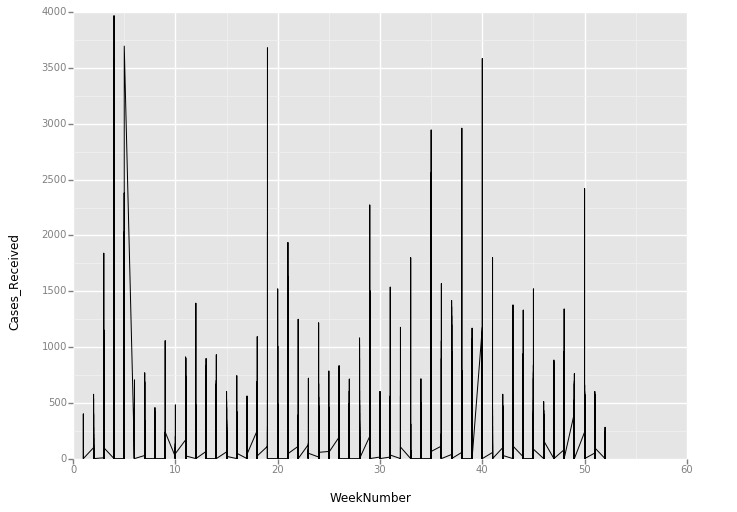

<ggplot: (165298852216)>

In [8]:
from ggplot import *

ggplot(WEEKLY, aes(x='WeekNumber', y='Cases_Received')) + geom_line()

In [10]:
from bokeh.charts import BoxPlot

B1 = BoxPlot(WEEKLY, values='Cases_Received', label='Pre-Post Policy Chg',
            title='Daily Cases Received Measured at SKU Level, Grouped by Supplier', 
            plot_width=1300, plot_height=900)
show(B1)
output_file('V:\\Washburn\\Operations Research\\Inbound Shipments\\Plots\\Daily Cases Received by Supplier.html')

C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


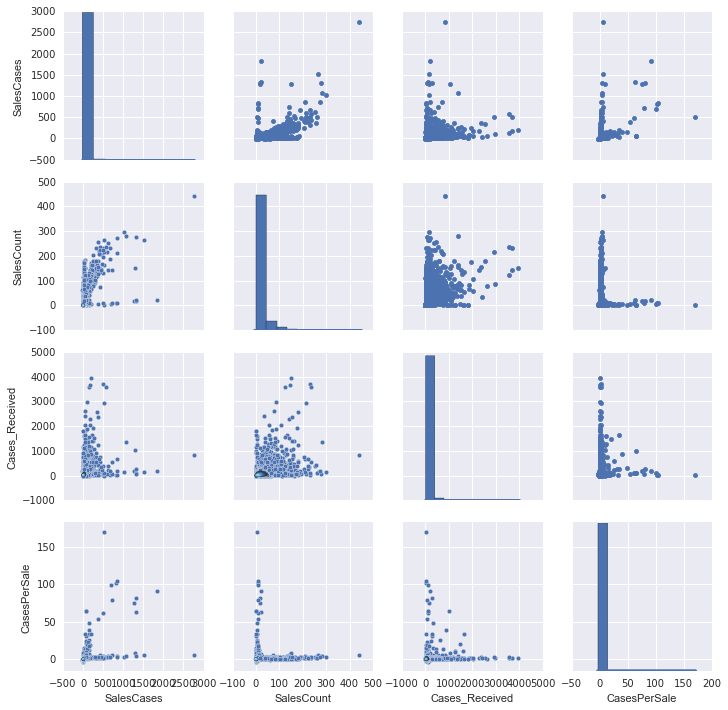

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white')
sns.set()

g = sns.pairplot(WEEKLY[['SalesCases','SalesCount','Cases_Received','CasesPerSale']])
g.map_lower(sns.kdeplot, cmap='Blues_d')
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

In [166]:
grp_cols = ['Warehouse','Supplier_Name','Product','ProductId']
temp = pd.DataFrame(WEEKLY.groupby(grp_cols).agg({np.sum, np.mean, np.std})).reset_index(drop=False)
print(temp.head())
#temp.to_csv('C:/Users/pmwash/Desktop/Disposable Docs/AGGREGATED.csv'); del temp

     Warehouse                    Supplier_Name  \
                                                  
0  Kansas City  AGAVE LOCO LLC/MHW LTD   804505   
1  Kansas City  ATLAS IMPORTS            802721   
2  Kansas City  AUGUSTA WINE CO          800801   
3  Kansas City  AUGUSTA WINE CO          800801   
4  Kansas City  BEAM GLOBAL SPIRITS/WINE 800684   

                            Product ProductId WeekNumber               \
                                                     std   sum   mean   
0                  RUM CHATA 10/SLV   4200509     15.155  1378 26.500   
1  SAMS DICELLO MOSCATO D ASTI DOCG   2722504     15.155  1378 26.500   
2                   AUGUSTA ICEWINE   8010066     15.155  1378 26.500   
3                    AUGUSTA NORTON   8010114     15.155  1378 26.500   
4    EFFEN BLACK CHERRY VODKA (6IN)   1021017     15.155  1378 26.500   

  SalesCases                ...   SalesCount CasesPerSale               \
         std     sum  mean  ...         mean          st

Coefficients: 
 [[ 2.46251511  0.71145197]]
Mean squared error: 306.52
Variance score: 0.93
     Warehouse ProductId                         Product WeekNumber  \
                                                               mean   
0  Kansas City   1021017  EFFEN BLACK CHERRY VODKA (6IN)     26.500   
1  Kansas City    111906                   JAMESON IRISH     26.500   
2  Kansas City    111954      JAMESON IRISH BLACK BARREL     26.500   
3  Kansas City    119994                SEAG LIME TW GIN     26.500   
4  Kansas City    120019              SEAG GIN 80 10/SLV     26.500   

  SalesCases Cases_Received WeeksBetweenReceipts Full_Pallets Pallet_Levels  \
        mean           mean                 mean         mean          mean   
0      3.614         11.846                1.692        0.106         2.962   
1      4.023         20.423                3.188        0.454         4.085   
2      2.434         13.731                2.579        0.245           inf   
3      4.725   

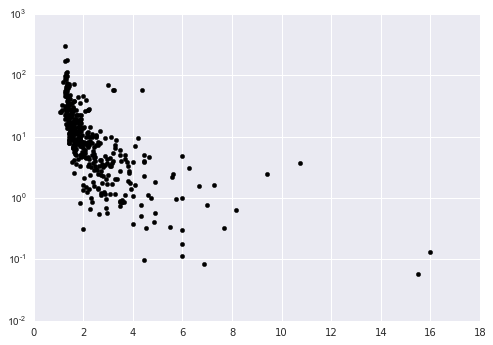

In [165]:
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.dummy import DummyClassifier

the_sums = pd.DataFrame(WEEKLY.groupby(grp_cols).agg({np.mean})).reset_index(drop=False)

model = linear_model.LinearRegression()
X = the_sums[['SalesCases','WeeksBetweenReceipts']] #'SalesCount','Supplier_Name'
Y = the_sums[['Cases_Received']]
model.fit(X, Y)
Y_predict = model.predict(X)

print('Coefficients: \n', model.coef_)

print("Mean squared error: %.2f"
      % np.mean((model.predict(X) - Y) ** 2))

print('Variance score: %.2f' % model.score(X, Y))

print(the_sums.head())
print('R-squared = %.3f' % r2_score(Y, Y_predict))

plt.yscale('log')
plt.scatter(the_sums.WeeksBetweenReceipts, the_sums.SalesCases, color='black')